In [72]:
# coding: utf-8
# 2020/인공지능/final/B511074/박준형
import sys, os
import argparse
import time
sys.path.append(os.pardir)
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle
import numpy as np
import math
from AReM import *


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)

        return y.T

    x = x - np.max(x)  # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        
        return dout


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        eMIN = -np.log(np.finfo(type(0.1)).max)
        xSafe = np.array(np.maximum(x, eMIN))
        self.out = (1.0 / 1 + np.exp(-xSafe))
        
        return self.out

    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        
        return dx

class tanh:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        self.out = np.tanh(x)
        
        return self.out
    
    def backward(self, dout):
        dx = dout * (1 - self.out**2)
        
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x, self.dw, self.db = None, None, None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dw = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.t = None
        self.y = None

    def forward(self, x, t):
        if t.ndim == 1: #one hot 안되어 있는 경우
            t = np.eye(6)[t]
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
            for key in params.keys():
                self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
                params[key] += self.v[key]
                
class Adagrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
            for key in params.keys():
                self.h[key] = grads[key] * grads[key]
                params[key] -= self.lr * grads[key] / np.sqrt(self.h[key] + 1e-7)
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)
            
class CustomOptimizer:
    pass

class Dropout:
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            
            return x * self.mask
        
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

class BatchNormalization:
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx
    
def weight_init_std(input, type = 'Relu'):
    """ 가중치 초깃값 """

    # he 초깃값 -> Relu
    if type is 'Relu':
        return np.sqrt(4.0 / input)
      
    # Xavier 초깃값 -> sigmoid, tanh
    return 1.0 / np.sqrt(input)
    
class Model:
    """
    네트워크 모델 입니다.

    """
    """제출 전 수정"""
    def __init__(self, layer_unit = [6, 50, 50, 6], lr=0.01, dr = False):
        """
        클래스 초기화
        """
        self.dr = dr
        self.params = {}
        """제출 전 수정"""
        self.W = {}
        self.layer_size = len(layer_unit) # 레이어 수
        self.__init_weight(layer_unit)
        self.layers = OrderedDict()
        self.last_layer = None
        self.__init_layer()
        self.optimizer = Adam(lr)
        
        """제출 전 수정"""
        self.normalize = True
        self.standardze = True        
        
    def __init_layer(self):
        """
        레이어를 생성하시면 됩니다.
        """
        # Input layer -> hidden layer -> hidden...
        for i in range(self.layer_size - 2):
            self.layers['Affine{}'.format(i+1)] = \
                Affine(self.params['W{}'.format(i+1)], self.params['b{}'.format(i+1)])
            if self.dr:
                self.layers['Dropout{}'.format(i+1)] = Dropout()
            self.layers['Relu{}'.format(i+1)] = Relu()
        
        # hidden layer -> output
        i = self.layer_size - 1
        self.layers['Affine{}'.format(i)] = \
            Affine(self.params['W{}'.format(i)], self.params['b{}'.format(i)])
        
        self.last_layer = SoftmaxWithLoss()
        
    def __init_weight(self, unit):
        """
        레이어에 탑재 될 파라미터들을 초기화 하시면 됩니다.
        """
    
        for i in range(self.layer_size - 1):
            self.params['W{}'.format(i + 1)] = weight_init_std(unit[i], 'Relu') * np.random.randn(unit[i], unit[i + 1]) 
            self.params['b{}'.format(i + 1)] = np.zeros(unit[i + 1])
        for i in range(self.layer_size - 1):
            self.W['W{}'.format(i + 1)] = self.params['W{}'.format(i + 1)].copy()
            self.W['b{}'.format(i + 1)] = self.params['b{}'.format(i + 1)].copy()
        
    
    def update(self, x, t):
        """
        train 데이터와 레이블을 사용해서 그라디언트를 구한 뒤
         옵티마이저 클래스를 사용해서 네트워크 파라미터를 업데이트 해주는 함수입니다.

        :param x: train_data
        :param t: test_data
        """
        
        grads = self.gradient(x, t)
        self.optimizer.update(self.params, grads)

    def predict(self, x):
        """
        데이터를 입력받아 정답을 예측하는 함수입니다.

        :param x: data
        :return: predicted answer
        """
        
        if self.normalize:
            x = x.astype(np.float32)
            x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

        if self.standardze:
            x = x.astype(np.float32)
            x -= np.mean(x, axis=0)
            x /= np.std(x, axis=0)
            
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        """
        데이터와 레이블을 입력받아 로스를 구하는 함수입니다.
        :param x: data
        :param t: data_label
        :return: loss
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)


    def gradient(self, x, t):
        """
        train 데이터와 레이블을 사용해서 그라디언트를 구하는 함수입니다.
        첫번째로 받은데이터를 forward propagation 시키고,
        두번째로 back propagation 시켜 grads에 미분값을 리턴합니다.
        :param x: data
        :param t: data_label
        :return: grads
        """
        # forward
        self.loss(x, t)
        
        # backward
        dout = self.last_layer.backward(1)
        
        la = list(self.layers.values())
        la.reverse()
        
        for layer in la:
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        
        for i in range(self.layer_size - 1):
            grads['W{}'.format(i+1)] = self.layers['Affine{}'.format(i+1)].dw
            grads['b{}'.format(i+1)] = self.layers['Affine{}'.format(i+1)].db
        
        return grads

    def save_params(self, file_name="params.pkl"):
        """
        네트워크 파라미터를 피클 파일로 저장하는 함수입니다.

        :param file_name: 파라미터를 저장할 파일 이름입니다. 기본값은 "params.pkl" 입니다.
        """
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        """
        저장된 파라미터를 읽어와 네트워크에 탑재하는 함수입니다.

        :param file_name: 파라미터를 로드할 파일 이름입니다. 기본값은 "params.pkl" 입니다.
        """
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        self.__init_layer()



In [73]:
class Trainer:
    """
    ex) 200개의 훈련데이터셋, 배치사이즈=5, 에폭=1000 일 경우 :
    40개의 배치(배치당 5개 데이터)를 에폭 갯수 만큼 업데이트 하는것.=
    (200 / 5) * 1000 = 40,000번 업데이트.

    ----------
    network : 네트워크
    x_train : 트레인 데이터
    t_train : 트레인 데이터에 대한 라벨
    x_test : 발리데이션 데이터
    t_test : 발리데이션 데이터에 대한 라벨
    epochs : 에폭 수
    mini_batch_size : 미니배치 사이즈
    learning_rate : 학습률
    verbose : 출력여부

    ----------
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 learning_rate=0.01, verbose=True, layers = [6, 12, 12, 12, 12 ,6]):
        self.network = network
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = int(epochs)
        self.batch_size = int(mini_batch_size)
        self.lr = learning_rate
        self.verbose = verbose
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = int(max(self.train_size / self.batch_size, 1))
        self.max_iter = int(self.epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

        """제출 전 수정"""
        self.layers = layers # List : ex) [6, 12, 12, 12, 12, 6]
        self.layer_size = len(layers)
        
        
    def train_step(self):
        # 렌덤 트레인 배치 생성
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        # 네트워크 업데이트
        self.network.update(x_batch, t_batch)
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            train_acc, _ = self.accuracy(self.x_train, self.t_train)
            test_acc, _ = self.accuracy(self.x_test, self.t_test)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose is False: print(
                "=== epoch:", str(round(self.current_epoch, 3)), ", iteration:", str(round(self.current_iter, 3)),
                ", train acc:" + str(round(train_acc, 3)), ", test acc:" + str(round(test_acc, 3)), ", train loss:" + str(round(loss, 3)) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc, inference_time = self.accuracy(self.x_test, self.t_test)

        if self.verbose:
            """제출 전 수정"""
            file = open('./Result/SGD/[si_{}]_[ep_{}]_[ba_{}]_[lr_{}]_[la_{}].txt'\
                        .format(self.layer_size, self.epochs, self.batch_size, self.lr, self.layers), 'w')
            file.write("=============== Final Test Accuracy ===============\n")
            file.write("test acc: %f,  " % test_acc)
            file.write("inference_time: %f\n" % inference_time)
            file.close()
        else:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc) + ", inference_time:" + str(inference_time))
            print('[size = {}][epoch = {}][batch = {}][lr = {}][layer = {}]'\
                        .format(self.layer_size, self.epochs, self.batch_size, self.lr, self.layers))
            print("")

    def accuracy(self, x, t):
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0
        start_time = time.time()

        for i in range(int(x.shape[0] / self.batch_size)):
            tx = x[i * self.batch_size:(i + 1) * self.batch_size]
            tt = t[i * self.batch_size:(i + 1) * self.batch_size]

            y = self.network.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        inference_time = (time.time() - start_time) / x.shape[0]

        return acc / x.shape[0], inference_time

class Tester:
    """
    test 해주는 클래스. 수정불가
    ----------
    network : 네트워크
    x_test : 발리데이션 데이터
    t_test : 발리데이션 데이터에 대한 라벨
    mini_batch_size : 미니배치 사이즈
    verbose : 출력여부

    ----------
    """
    def __init__(self, network, x_test, t_test, mini_batch_size=100, verbose=True):
        self.network = network
        self.x_test = x_test
        self.t_test = t_test
        self.batch_size = int(mini_batch_size)
        self.verbose = verbose
        self.train_size = x_test.shape[0]

    def accuracy(self, x, t):
        """
        수정불가
        """
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0
        start_time = time.time()

        for i in range(int(x.shape[0] / self.batch_size)):
            tx = x[i * self.batch_size:(i + 1) * self.batch_size]
            tt = t[i * self.batch_size:(i + 1) * self.batch_size]

            y = self.network.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        inference_time = (time.time()-start_time)/x.shape[0]

        return acc / x.shape[0], inference_time

class arg:
    def __init__(self, epochs, mini_batch_size, learning_rate, sf):
        self.sf = sf
        self.epochs =  epochs
        self.mini_batch_size = mini_batch_size
        self.learning_rate = learning_rate
        
if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description="train.py --help 로 설명을 보시면 됩니다."
#                                                  "사용예)python train.py --sf=myparam --epochs=10")
#     parser.add_argument("--sf", required=False, default="params.pkl", help="save_file_name")
#     parser.add_argument("--epochs", required=False, default=20, help="epochs : default=20")
#     parser.add_argument("--mini_batch_size", required=False, default=100, help="mini_batch_size : default=100")
#     parser.add_argument("--learning_rate", required=False, default=0.01, help="learning_rate : default=0.01")
#     args = parser.parse_args()

    # 데이터셋 탑재
    (x_train, t_train), (x_test, t_test) = load_AReM(one_hot_label=False)
    
    """제출전 수정"""

    testacc=[]
    
    # hyperparameter
    epochs = [100]
    batchs = [100]
    learningRate = [0.005]
    layer_unit_list = [[6, 512, 512, 512, 512, 512, 6]]
    for epoch in epochs:
        for batch in batchs:
            for lr in learningRate:
                for layer_unit in layer_unit_list:
                    sf = './Params/Adam/params[si_{}]_[ep_{}]_[ba_{}]_[lr_{}]_[la_{}].pkl'\
                        .format(len(layer_unit), epoch, batch, lr, layer_unit)
                    args = arg(epoch, batch, lr, sf)

                    # 모델 초기화
                    network = Model(layer_unit)

                    # 트레이너 초기화
                    trainer = Trainer(network, x_train, t_train, x_test, t_test,
                                      epochs=args.epochs, mini_batch_size=args.mini_batch_size,
                                      learning_rate=args.learning_rate, verbose=False, 
                                      layers = layer_unit)

                    # 트레이너를 사용해 모델 학습
                    trainer.train()
                    
                    # 파라미터 보관
                    network.save_params(args.sf) 
                    
                    # loss와 training accuracy를 Plot
                    x = np.arange(len(trainer.train_loss_list))
                    plt.plot(x, trainer.train_loss_list)
                    plt.legend(["loss"]) # 각주
                    plt.title('layerSize: {}, epoch : {}, batch : {}, lr: {} layer: {}'\
                              .format(len(layer_unit), epoch, batch, lr, layer_unit))
                    plt.savefig('./Result/Adam/[si_{}]_[ep_{}]_[ba_{}]_[lr_{}]_[la_{}].png'\
                                .format(len(layer_unit), epoch, batch, lr, layer_unit), dpi=100)
                    plt.show()
                    plt.clf()

=== epoch: 1 , iteration: 0 , train acc:0.181 , test acc:0.186 , train loss:12.884 ===
=== epoch: 2 , iteration: 250 , train acc:0.671 , test acc:0.662 , train loss:0.613 ===
=== epoch: 3 , iteration: 500 , train acc:0.702 , test acc:0.692 , train loss:0.604 ===
=== epoch: 4 , iteration: 750 , train acc:0.694 , test acc:0.681 , train loss:0.608 ===


KeyboardInterrupt: 

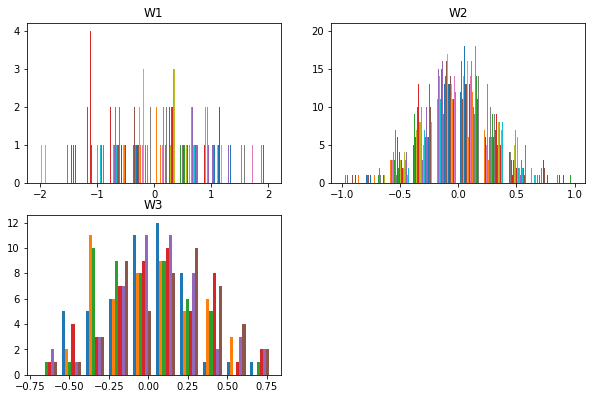

In [46]:
i=1
plt.figure(figsize = [10,10])
plt.title("histogram")

for key,val in network.W.items():
      if key[0] == 'W':
            plt.subplot(math.ceil((network.layer_size+1)/2),2,i)
            plt.title(key)
            plt.hist(val,bins=10)
            i+=1
                #     print("Network params Saved ")

#                     (_, _), (x_test, t_test) = load_AReM(one_hot_label=False)

#                     network = Model(layer_unit)

#                     tester = Tester(network, x_test, t_test)
#                 #     args = arg()

#                     network.load_params(args.sf)


#                     # 배치사이즈100으로 accuracy test, 다른 배치사이즈로 학습했다면 결과가 달라질 수 있습니다.
#                     test_acc, inference_time = tester.accuracy(x_test, t_test)
# #                     file = open('./Result/SGD/[si_{}]_[ep_{}]_[ba_{}]_[lr_{}]_[la_{}].txt'\
# #                                         .format(len(layer_unit), epoch, batch, lr, layer_unit), 'a')
# #                     file.write("=============== Final Test Accuracy ===============\n")
# #                     file.write("test acc: %f,  " % test_acc)
# #                     file.write("inference_time: %f\n" % inference_time)
# #                     file.close()
#                     print("=============== Final Test Accuracy ===============")
#                     print("test acc:" + str(round(test_acc,3)) + ", inference_time:" + str(inference_time))
#                     print("\n=========================================================\n\n\n")

In [51]:


# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')

import pickle
import numpy as np


def _change_one_hot_label(X):
    T = np.zeros((X.size, 6))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T


def load_AReM(normalize=False, standardze=False, one_hot_label=False):
    """AReM 데이터셋 읽기

    Parameters
    ----------
    normalize : 데이터를 0.0~1.0 사이의 값으로 정규화할지 정한다.
    standardze : 데이터를 평균을 기준으로 어느정도 떨어지게 만들지 정한다.
    one_hot_label :
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.

    Returns
    -------
    (트레인 데이터, 트레인 정답),(발리데이션 데이터, 발리데이션 정답)
    """
    #assert (not (normalize & standardze)), "Choose one"
    with open('dataset.pkl', 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_', 'val_'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] = (dataset[key] - np.min(dataset[key], axis=0)) / (
                        np.max(dataset[key], axis=0) - np.min(dataset[key], axis=0))

    if standardze:
        for key in ('train_', 'val_'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] -= np.mean(dataset[key], axis=0)
            dataset[key] /= np.std(dataset[key], axis=0)

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['val_label'] = _change_one_hot_label(dataset['val_label'])

    return (dataset['train_'], dataset['train_label']), (dataset['val_'], dataset['val_label'])

(x_train, t_train), (x_test, t_test) = load_AReM(normalize = False, standardze=False, one_hot_label=False)

print(x_train)
print(x_train.shape)
print(t_train)
print(x_train.shape)
print(x_test)
print(x_test.shape)
print(t_test)
print(t_test.shape)

[[32.    5.24 21.    0.82 18.33  1.25]
 [33.    4.95 17.    3.08 14.75  5.85]
 [53.5   0.5  13.5   0.87 16.75  0.83]
 ...
 [26.5   0.87  4.67  2.05  5.5   1.12]
 [39.67  0.47  9.25  0.43 10.33  1.25]
 [26.    0.    0.    0.   18.5   0.5 ]]
(25055, 6)
[4 4 3 ... 3 3 5]
(25055, 6)
[[21.75  0.83 12.5   2.06 21.75  1.3 ]
 [37.25  1.3  22.    5.87 20.75  4.44]
 [41.75  2.59  9.5   5.22 16.5   2.96]
 ...
 [36.    0.    8.5   2.69 21.    0.  ]
 [42.    0.   18.25  0.43 19.25  0.83]
 [38.5   2.6  13.    2.83 15.    4.97]]
(8351, 6)
[5 4 0 ... 2 2 0]
(8351,)
